In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4) # type: ignore

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2) # type: ignore

Files already downloaded and verified
Files already downloaded and verified


In [2]:
from torch.utils.tensorboard import SummaryWriter  # type: ignore

from tensorboard_tools import matplotlib_imshow, clear_tensorboard_runs

clear_tensorboard_runs("runs/cifar10")

writer = SummaryWriter("runs/cifar10")

Cleared all content in runs/cifar10


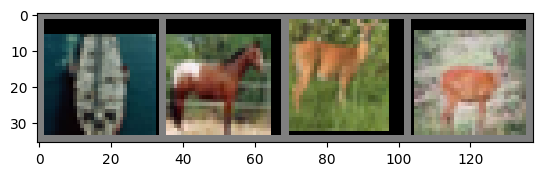

In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

In [4]:
from cvit.model import Net

net = Net()
writer.add_graph(net, images)
writer.close()

In [5]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from general_trainer.trainer import GeneralTrainer
from general_trainer.optim_schedule import ScheduleOptim


def cal_loss(data, net):
    input_tensor = data[0].to("cuda")
    target = data[1].to("cuda")
    
    output = net(input_tensor)
    loss = criterion(output, target)
    return output, loss


def cal_correct(data, output):
    target = data[1].to("cuda")
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    element_count = target.size(0)
    return correct, element_count

optim_scheduler = ScheduleOptim(optimizer, scheduler=scheduler)

trainer = GeneralTrainer(
    net,
    criterion,
    trainloader,
    optimizer,
    testloader,
    scheduler=optim_scheduler,
    cal_loss=cal_loss,
    cal_correct=cal_correct,
    writer=writer,
)
trainer.training(150)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from cvit.model import Net

model = Net()
model.load_state_dict(torch.load("model_26.pth"))

transform_test = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)  # type: ignore


model.to('cuda')
model.eval()
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {(100 * correct / total):.2f}%')


test()

Files already downloaded and verified
Accuracy: 89.99%


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # type: ignore
from cvit.model import Net


transform_test = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(testset, batch_size=24, shuffle=False, num_workers=2)  # type: ignore

model = Net()
model.eval()

writer = SummaryWriter("runs/cifar10")

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # 找出预测错误的样本
        incorrect_idx = torch.nonzero(predicted != labels).squeeze()
        for i, idx in enumerate(incorrect_idx):
            if i > 10:
                break
            image = images[idx]  # 获取错误图像
            true_label = testset.classes[labels[idx]]  # 真实标签
            predicted_label = testset.classes[predicted[idx]]  # 预测标签

            # 将图像写入TensorBoard
            writer.add_image(f"Error_{idx}", image, global_step=idx, dataformats="CHW")
            writer.add_text(
                f"Label_{idx}",
                f"True: {true_label}, Predicted: {predicted_label}",
                global_step=idx,
            )

writer.close()